## Kaggle 개발환경에서 재생하기

In [1]:
!pip install keras
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     |████████████████████████████████| 1.3 MB 824 kB/s 
/kaggle/input/cv-test/submission.csv
/kaggle/input/cv-test/train.csv
/kaggle/input/cv-test/test.csv
/kaggle/input/model1/model1.csv


위 코드는 kaggle에서 노트북을 돌릴 시 필요한 과정이다

## Python Import

In [2]:
# Import Necessary Libraries from Python
import warnings
warnings.filterwarnings("ignore")

## Basic Import ##
import pandas as pd
import numpy as np
import sklearn
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## Tensorflow ## 
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array # Image Related

# Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

# Modelling
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras import optimizers

2021-09-24 23:39:07.477681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Call Dataset

In [3]:
root = '/kaggle/input/cv-test/'
train = pd.read_csv(root+'/train.csv')
test = pd.read_csv(root+'/test.csv')
submission = pd.read_csv(root+'/submission.csv')

In [4]:
# Train Dataset 보기
print("데이터의 형태(행, 열):", train.shape) 
train.head()

데이터의 형태(행, 열): (2048, 787)


,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


In [5]:
# Test Dataset 보기
print("데이터의 형태(행, 열):", test.shape) 
test.head()

데이터의 형태(행, 열): (20480, 786)


,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,...,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,...,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,...,4,3,1,4,0,2,1,2,3,4


In [6]:
# Submission Dataset 보기
print("데이터의 형태(행, 열):", test.shape)
submission.head()

데이터의 형태(행, 열): (20480, 786)


,id,digit
0,2049,0
1,2050,0
2,2051,0
3,2052,0
4,2053,0


Train과 Test에서의 차이는 Test Dataset에 hidden number가 병기가 안 되어있다. 이를 표시해서 구하는 것이 submission.csv 를 출력할 때 필요하다.

train과 submission의 index가 2049부터 시작하는 것 보아서 처음에 같이 있는 것을 나눈 것 같다.

우선 봐야 할 것은 뒤에 0~783까지 픽셀 값들은 이미지를 표현하기 위한 것인데, 이를 학습할 수 있도록 전처리 해야한다.

또한, train과 test 데이터 개수 차이가 많이 나므로 이에 대한 대책도 필요하고, 편향된 데이터 인지도 분석이 필요하다. 

## EDA (Exploratory Data Analysis)

[Text(0.5, 0, 'Digit(Target)'), Text(0, 0.5, 'Count')]

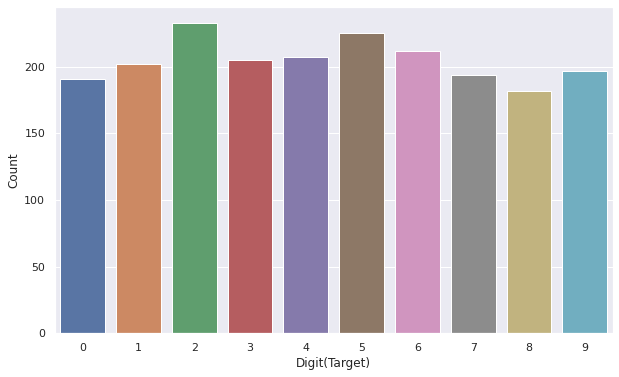

In [7]:
# 숫자 분포
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="digit", data=train)
ax.set(xlabel='Digit(Target)', ylabel='Count')

[Text(0.5, 0, 'Letter'), Text(0, 0.5, 'Count')]

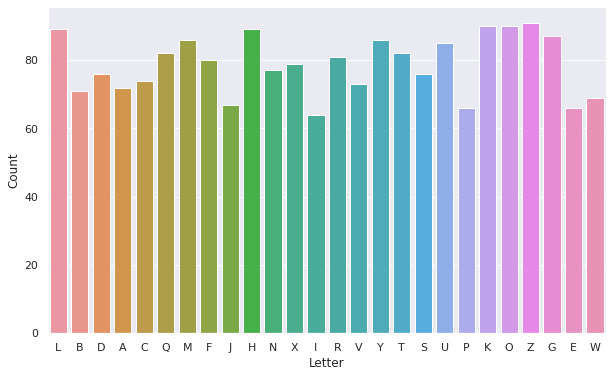

In [8]:
plt.figure(figsize=(10, 6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="letter", data=train)
ax.set(xlabel='Letter', ylabel='Count')

데이터가 imbalanced 한 것은 아니여서 별도의 조작은 필요 없을 것 같다.

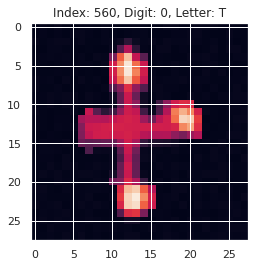

In [9]:
# 이미지 조회
idx = 560
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int) # 28*28 ndarray 꼴로 변환 
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter)) # 위의 줄 출력
plt.imshow(img)
plt.show()

이미지를 reshape해서 저장을 하는 것이 좋아보인다.

## Preprocessing

In [10]:
# 불필요한 column 제거
train2 = train.drop(['id','digit','letter'],1)
test2 = test.drop(['id','letter'],1)

In [11]:
# 데이터프레임(pd)을 ndarray(np) 형식으로 변환 후 reshape
train2 = train2.values.reshape(-1,28,28,1)
test2 = test2.values.reshape(-1,28,28,1)

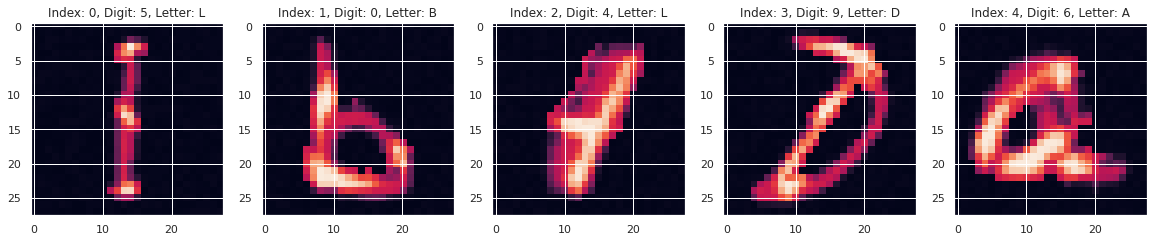

In [12]:
plt.figure(figsize=(20,4))
for i in range(5):
    img = train2[i].reshape(28,28)
    digit = train.loc[i, 'digit']
    letter = train.loc[i, 'letter']
    plt.subplot(1,5, i + 1)
    plt.title('Index: %i, Digit: %s, Letter: %s'%(i, digit, letter))
    plt.imshow(img)

다음 예시들을 보니 데이터셋은 알파벳인 EMNIST 위에 MNIST를 겹친 후, 알파벳이 아닌 부분을 제외하는 형태로 만들어주었다.

따라서, 겹치지 않은 알파벳 부분을 제거해 준 다음에 원래 MNIST 방식으로 학습할 수 있도록 모델을 만들어준다.

In [13]:
# data normalization
train2 = train2/255.
test2 = test2/255.

# 어두운 알파벳 부분 제거
threshold = 0.6
train2[train2 < threshold] = 0
test2[test2 < threshold] = 0

In [14]:
def test_imgs(imgs): # 이미지 10개를 보여주며 경향성을 나타낸다.
    plt.figure(figsize=(20, 5))
    for i in range(10):
        ax = plt.subplot(2, 10, i + 1)
        plt.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [15]:
y = train['digit'] # Digit 열에 있는 결과값들 
y_train = np.zeros((len(y), len(y.unique()))) # y_train을 0으로 초기화한다
for i, digit in enumerate(y):
    y_train[i, digit] = 1 # 이를 통해 One-Hot Encoding이 가능하다

In [16]:
x_train1 = np.repeat(train2, 3, axis=1)
x_train2 = np.repeat(x_train1, 3, axis=2)
x_test1 = np.repeat(test2, 3, axis=1)
x_test2 = np.repeat(x_test1, 3, axis=2)

In [17]:
print(x_train2.shape)
print(x_test2.shape)

(2048, 84, 84, 1)
(20480, 84, 84, 1)


In [18]:
'''
idg = ImageDataGenerator(width_shift_range=5, height_shift_range=5, rotation_range=10, zoom_range=0.05)  
idg2 = ImageDataGenerator()
    
train_generator = idg.flow(x_train,y_train)
valid_generator = idg2.flow(x_valid,y_valid)
test_generator = idg2.flow(test2,shuffle=False)
'''
datagen = ImageDataGenerator(rotation_range=10,  zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)
# idg2 = ImageDataGenerator()

In [19]:
'''
sample_data = train2[idx].reshape(1,28,28,1)
sample_generator = idg.flow(sample_data, batch_size=1)

plt.figure(figsize=(16,10))

for i in range(9) : 
    plt.subplot(3,3,i+1)
    plt.imshow(sample_generator[0].reshape(28,28))
'''

'\nsample_data = train2[idx].reshape(1,28,28,1)\nsample_generator = idg.flow(sample_data, batch_size=1)\n\nplt.figure(figsize=(16,10))\n\nfor i in range(9) : \n    plt.subplot(3,3,i+1)\n    plt.imshow(sample_generator[0].reshape(28,28))\n'

## Previous Modelling

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler # ModelCheckpoint

LR = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x) #learning rate scheduler
es = EarlyStopping(patience=20, verbose=1)

In [21]:
# Convolutional Layer, FullyConnected Layer 뒤에 Dropout 추가하기
'''
model = Sequential()

model.add(Conv2D(128,activation='relu',input_shape=(28,28,1),kernel_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,activation='relu',kernel_size=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1000,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
learning_history = model.fit(train_generator, validation_data=valid_generator, epochs=100, callbacks=[es,mc,reLR])
hist = pd.DataFrame(learning_history.history)
'''


"\nmodel = Sequential()\n\nmodel.add(Conv2D(128,activation='relu',input_shape=(28,28,1),kernel_size=(5,5), padding='same'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(128,activation='relu',kernel_size=(2,2), padding='same'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D((2,2)))\nmodel.add(Dropout(0.2))\n\nmodel.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))\nmodel.add(BatchNormalization())\nmodel.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))\nmodel.add(BatchNormalization())\nmodel.add(MaxPooling2D((2,2)))\nmodel.add(Dropout(0.2))\n\nmodel.add(Flatten())\n\nmodel.add(Dense(1000,activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Dropout(0.3))\n\nmodel.add(Dense(10,activation='softmax'))\n\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])\nlearning_history = model.fit(train_generator, validation_data=valid_generator, epochs=100, callbacks=[es,mc,reLR])\nhist = pd.DataFrame(

In [22]:
# cross validation
'''
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

result = 0
for train_index, valid_index in skf.split(train2,train['digit']) :
    mc = ModelCheckpoint('best_cvision.h5',save_best_only=True, verbose=1) # 가장 우수한 결과만 저장
    model = Sequential()

    model.add(Conv2D(128,activation='relu',input_shape=(28,28,1),kernel_size=(5,5), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,activation='relu',kernel_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.25))

    model.add(Dense(10,activation='softmax'))
  
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['acc'])
      
    history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid))
    learning_history = model.fit(train_generator, validation_data=valid_generator, epochs=100, callbacks=[es,mc,reLR])
    
    # history
    hist = pd.DataFrame(learning_history.history)
    hist['val_loss'].min()
    
    # predict
    model.load_weights('best_cvision.h5')
    result += model.predict(test_generator,verbose=True)/5
'''

"\nfrom sklearn.model_selection import StratifiedKFold\nskf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)\n\nresult = 0\nfor train_index, valid_index in skf.split(train2,train['digit']) :\n    mc = ModelCheckpoint('best_cvision.h5',save_best_only=True, verbose=1) # 가장 우수한 결과만 저장\n    model = Sequential()\n\n    model.add(Conv2D(128,activation='relu',input_shape=(28,28,1),kernel_size=(5,5), padding='same'))\n    model.add(BatchNormalization())\n    model.add(Conv2D(128,activation='relu',kernel_size=(2,2), padding='same'))\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D((2,2)))\n    model.add(Dropout(0.25))\n\n    model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))\n    model.add(BatchNormalization())\n    model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D((2,2)))\n    model.add(Dropout(0.25))\n\n    model.add(Dense(10,activation='softmax'))\n  \

## Modelling

In [23]:

def new_model():
    inputs = Input(shape = (84,84,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.4)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [24]:
new_model().summary()

2021-09-24 23:39:19.280467: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-24 23:39:19.284016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-24 23:39:19.335393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-24 23:39:19.336028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-24 23:39:19.336090: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-24 23:39:19.367622: I tensorflow/stream_executor/platform/def

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_1 (Batch (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 42, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 42, 64)        0     

In [25]:
# history = new_model().fit(train_generator, epochs=100, callbacks=[LR, es], verbose = 1)
history = new_model().fit(datagen.flow(x_train2, y_train, batch_size=16), epochs=100, steps_per_epoch = x_train2.shape[0]//16, callbacks=[LR], verbose = 1 )

2021-09-24 23:39:21.778308: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-24 23:39:21.785408: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000185000 Hz


Epoch 1/100


2021-09-24 23:39:23.163793: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-24 23:39:23.921946: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-24 23:39:23.937806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


128/128 [==============================] - 10s 22ms/step - loss: 4.6770 - accuracy: 0.2536
Epoch 2/100
128/128 [==============================] - 3s 24ms/step - loss: 2.8237 - accuracy: 0.3364
Epoch 3/100
128/128 [==============================] - 3s 22ms/step - loss: 2.4787 - accuracy: 0.4080
Epoch 4/100
128/128 [==============================] - 3s 24ms/step - loss: 2.3172 - accuracy: 0.4508
Epoch 5/100
128/128 [==============================] - 3s 26ms/step - loss: 2.2612 - accuracy: 0.4383
Epoch 6/100
128/128 [==============================] - 3s 23ms/step - loss: 2.0952 - accuracy: 0.4920
Epoch 7/100
128/128 [==============================] - 3s 22ms/step - loss: 2.0942 - accuracy: 0.4874
Epoch 8/100
128/128 [==============================] - 3s 23ms/step - loss: 2.0103 - accuracy: 0.4975
Epoch 9/100
128/128 [==============================] - 3s 24ms/step - loss: 1.9919 - accuracy: 0.4936
Epoch 10/100
128/128 [==============================] - 3s 22ms/step - loss: 1.8990 - accurac

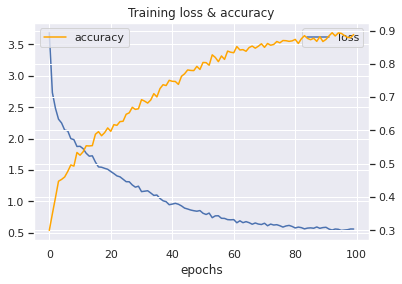

<Figure size 432x288 with 0 Axes>

In [26]:
plt.title('Training loss & accuracy')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.twinx().plot(history.history['accuracy'], color="orange")
plt.legend(['accuracy'])

plt.figure()
plt.show()

## Submission

In [27]:
submission['digit'] = np.argmax(new_model().predict(x_test2), axis=1)
# 각 digit에 만든 모델을 적용시켜 값 중 가장 큰 값의 index를 출력 (그게 곧 숫자)
submission.head() # 앞의 값 5개 출력

,id,digit
0,2049,2
1,2050,6
2,2051,6
3,2052,3
4,2053,3


In [28]:
# 세 명이 학습시킨 모델 중 가장 결과가 좋았던 모델의 결과를 사용하여, 최종 결과값을 산출한다.
# submission["model_1"] = pd.read_csv(root+'/model1.csv')
# submission["model_2"] = pd.read_csv(root+'/model2.csv')
# submission["model_3"] = submission['digit']
# submission.head()

In [29]:
# from collections import Counter
# 3개 중 답이 갈릴 경우 더 우세하다고 판단한 모델로 결과값을 정합니다.
# for i in range(len(submission)) :
#    predicts = submission.loc[i, ['model_1','model_2','model_3']]
#    submission.at[i, "digit"] = Counter(predicts).most_common(n=1)[0][0]

In [30]:
# 최종 결과만 csv 파일 도출
# submission = submission[['id', 'digit']]
submission.to_csv('final_prediction_x3.csv', index=False)